In [1]:
# # Cuda
# import cv2
# gpu_frame = cv2.cuda.GpuMat()
# gpu_frame.upload(img_rgb)
# 
# gpu_canny = cv2.cuda.createCannyEdgeDetector(50, 100)
# edges_gpu = gpu_canny.detect(gpu_frame)
# 
# edges = edges_gpu.download()
# 
# cv2.imshow("Edges", edges)

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

DEBUG = True
DEBUG = False

def imshow(img, title=None):
    plt.title(title)
    plt.axis('equal')
    plt.imshow(img)
    plt.show()

def plot_images(pair_images_title: list[tuple[np.ndarray, str]]):
    # plot images, if there are more than 4 then use a grid with 4 columns
    fig, axes = plt.subplots(1, len(pair_images_title), figsize=(10, 10))
    axes = axes.flatten()
    for i, (img, title) in enumerate(pair_images_title):
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(rgb)
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Ingest

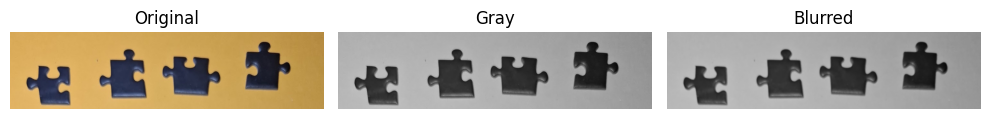

In [3]:


img_file="data/imgomatch.jpg"
img_bgr= cv2.imread(img_file, cv2.IMREAD_UNCHANGED)

# h,w = img_org.shape[:2]
# img_rgb = cv2.resize(img_org, (4*w, 4*h))

img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

plot_images([
    (img_bgr, "Original"),
    (img_gray, "Gray"),
    (img_blurred, "Blurred"),
])


## HSV filtering

In [4]:
if False:
    # Read image
    hsv_img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HSV)

    # Mouse callback function
    def pick_color(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:  # left mouse click
            pixel = hsv_img[y, x]  # HSV values
            h, s, v = pixel
            print(f"HSV: ({h}, {s}, {v})")

            # Optionally, show the color as a swatch
            swatch = np.zeros((100, 100, 3), np.uint8)
            swatch[:] = (h, s, v)
            swatch_bgr = cv2.cvtColor(swatch, cv2.COLOR_HSV2BGR)
            cv2.imshow("Picked Color", swatch_bgr)

    # Show image and set callback
    cv2.imshow("Image", img_rgb)
    cv2.setMouseCallback("Image", pick_color)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


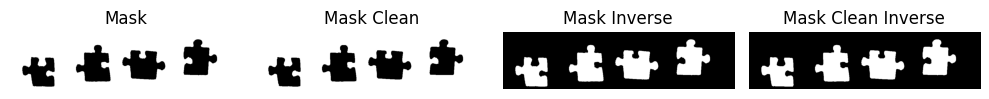

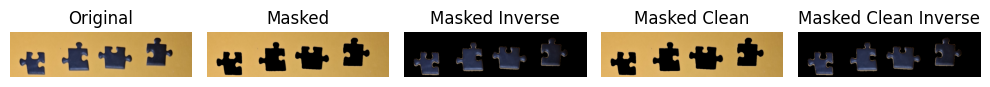

In [5]:
from numpy.ma import masked_singleton


hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
lower_bg = np.array([22, 171, 194])  # tweak
upper_bg = np.array([23, 157, 221])
lower_bg = np.array([15, 100, 100])
upper_bg = np.array([30, 255, 255])

mask = cv2.inRange(hsv, lower_bg, upper_bg)
mask_inv = cv2.bitwise_not(mask)

img_bgr_masked = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)
img_bgr_masked_inv = cv2.bitwise_and(img_bgr, img_bgr, mask=mask_inv)

kernel = np.ones((3, 3), np.uint8)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel, iterations=1)

mask_clean_inv = cv2.morphologyEx(mask_inv, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_clean_inv = cv2.morphologyEx(mask_clean_inv, cv2.MORPH_OPEN, kernel, iterations=1)

img_bgr_masked_clean = cv2.bitwise_and(img_bgr, img_bgr, mask=mask_clean)
img_bgr_masked_clean_inv = cv2.bitwise_and(img_bgr, img_bgr, mask=mask_clean_inv)

plot_images([
    (mask, "Mask"),
    (mask_clean, "Mask Clean"),
    (mask_inv, "Mask Inverse"),
    (mask_clean_inv, "Mask Clean Inverse"),
])

plot_images([
    (img_bgr, "Original"),
    (img_bgr_masked, "Masked"),
    (img_bgr_masked_inv, "Masked Inverse"),
    (img_bgr_masked_clean, "Masked Clean"),
    (img_bgr_masked_clean_inv, "Masked Clean Inverse"),
])


## Other imagines fix

### Adaptive Threshold

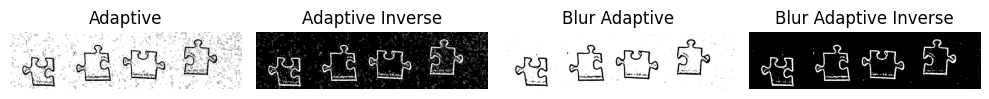

In [6]:
img_adaptive = cv2.adaptiveThreshold(
    img_gray,
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    11,
    2
)

img_inv_adaptive = cv2.adaptiveThreshold(
    img_gray,
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    11,
    2
)

img_blur_adaptive = cv2.adaptiveThreshold(
    img_blurred, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    11, 2
)
img_inv_blur_adaptive = cv2.adaptiveThreshold(
    img_blurred, 255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    11, 2
)

plot_images([
    (img_adaptive, "Adaptive"),
    (img_inv_adaptive, "Adaptive Inverse"),
    (img_blur_adaptive, "Blur Adaptive"),
    (img_inv_blur_adaptive, "Blur Adaptive Inverse"),
])





### Threshold

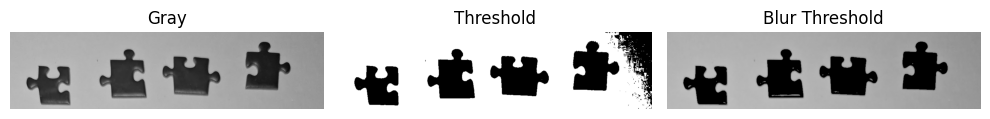

In [7]:
ret, img_thresh = cv2.threshold(
    img_gray,
    150,
    255,
    cv2.THRESH_BINARY
)


ret, img_blur_thresh = cv2.threshold(
    img_blurred,
    255, 
    cv2.THRESH_BINARY,
    11, 
    2
)


plot_images([
    (img_gray, "Gray"),
    (img_thresh, "Threshold"),
    (img_blur_thresh, "Blur Threshold"),
])


### OTSU

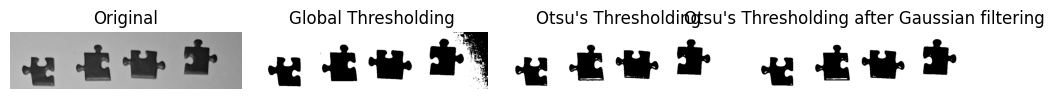

In [8]:
# Otsu's thresholding
ret2,th2 = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img_gray,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 

plot_images([
    (img_gray, "Original"),
    (img_thresh, "Global Thresholding"),
    (th2, "Otsu's Thresholding"),
    (th3, "Otsu's Thresholding after Gaussian filtering"),
])

# Find Contours

In [ ]:
img_best = cv2.cvtColor(img_bgr_masked_clean_inv, cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(img_best, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

class Item():
    def __init__(self, **kwargs):
        self.update(**kwargs)

    def update(self, **kwargs):
        self.__dict__.update(kwargs)

class Piece(Item):
    def __init__(self, name, **kwargs):
        super().__init__(**kwargs)
        self.name = name

    def __str__(self):
        return f"{self.name}"

class Edge(Item):
    def __init__(self, id, **kwargs):
        super().__init__(**kwargs)
        self.id = id

class Solution(Item):
    pass

pieces: list[Piece] = []
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)
    if area < 10000:
        continue
    # compute piece name from its position
    # col = int((x - w/2) * 13 / 4540)
    # row = int(1 + (y - h/2) * 13 / 4450)
    # name = chr(ord('A') + col) + str(row)
    name = f"piece_{i}"
    piece = Piece(
        name=name,
        int_contour=contour,
        contour=contour.astype(np.float64),  # convert to float for rotation
        area=area,
    )
    pieces.append(piece)
piece_by_name = dict([(piece.name, piece) for piece in pieces])



piece_0 10992.0
piece_3 13193.0
piece_2 13645.5
piece_1 14122.5


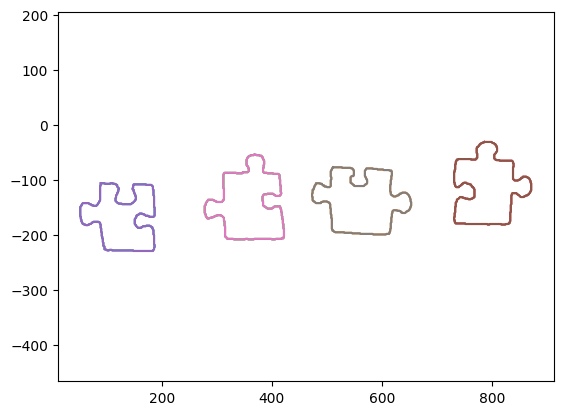

In [10]:
fig,ax = plt.subplots()

for piece in pieces:
    ax.axis('equal')
    ax.plot(piece.contour[:, :, 0], -piece.contour[:, :, 1])

pieces.sort(key= lambda piece: piece.area)

for piece in pieces:
    print(piece.name, piece.area)
    ax.plot(piece.contour[:, :, 0], -piece.contour[:, :, 1])


# Detect piece corners

In [11]:
from scipy.signal import find_peaks
FIND_PEAK_PROMINENCE = 500 # REDUCE TO INCREASE NUMBER OF PEAKS DETECTION

class LoopingList(list):
    def __getitem__(self, i):
        if isinstance(i, int):
            return super().__getitem__(i % len(self))
        else:
            return super().__getitem__(i)

def plot_contour(contour, **kwargs):
    plt.axis('equal')
    plt.plot(contour[:, :, 0], -contour[:, :, 1], **kwargs)

In [12]:
for piece in pieces:
    (cx, cy), cr = cv2.minEnclosingCircle(piece.int_contour)
    centered_contour = piece.int_contour - np.array([cx, cy])

    # ensure peaks are not at start or end of the distances array
    distances = np.sum(centered_contour**2, axis=2)[:, 0]
    distance_offset = np.argmin(distances)
    shifted_distances = np.concatenate([distances[distance_offset:], distances[:distance_offset]])

    # find peak distances
    peak_indices = [(distance_idx + distance_offset) % len(distances) for distance_idx in find_peaks(shifted_distances, prominence=FIND_PEAK_PROMINENCE)[0]]
    peak_indices.sort()
    piece.update(center=np.array([cx, cy]),
                 peak_indices=LoopingList(peak_indices),
    )

# Show the pieces having the smallest / highest number of peak indices
pieces.sort(key= lambda piece: len(piece.peak_indices))


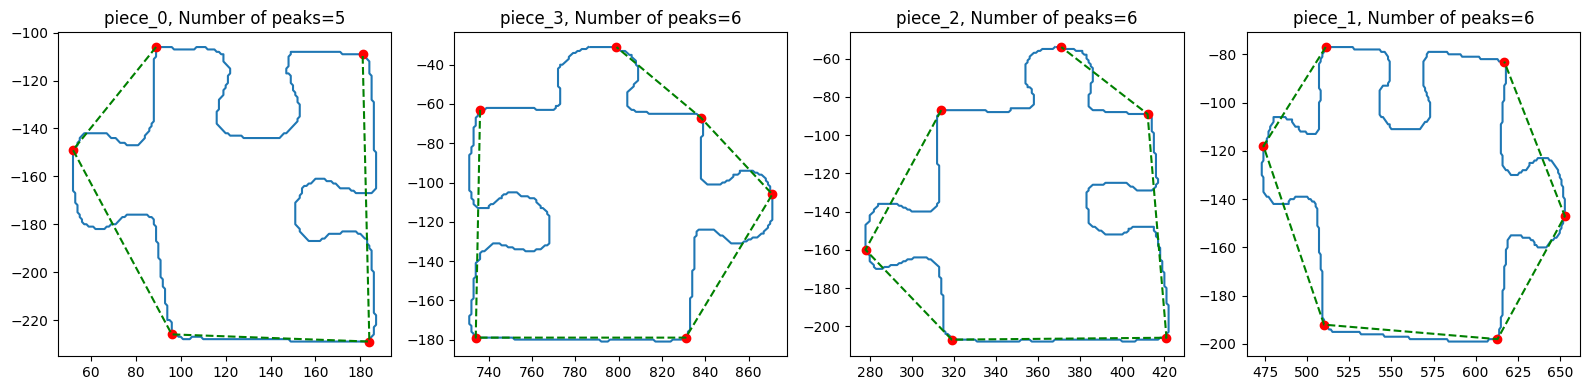

In [13]:
n_cols = min(4, len(pieces))
n_rows = math.ceil(len(pieces) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))

axes = axes.flatten() if (len(pieces) > 1) else [axes]

for ax, piece in zip(axes, pieces):
    ax.set_title(f"{piece.name}, Number of peaks={len(piece.peak_indices)}")
    ax.plot(piece.contour[:, :, 0], -piece.contour[:, :, 1])
    ax.plot(
        piece.contour[piece.peak_indices, :, 0],
        -piece.contour[piece.peak_indices, :, 1],
        marker='o', ls='', color='red'
    )
    # Connect peaks with lines
    peak_coords = piece.contour[piece.peak_indices, :, 0:2]
    ax.plot(
        peak_coords[:, :, 0],
        -peak_coords[:, :, 1],
        color='green', linestyle='--', marker=''
    )

# Hide unused subplots (if any)
for ax in axes[len(pieces):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


# Compute edges 

## Compute rectangles 

In [14]:
import math
import itertools
for piece in pieces:
    def compute_rectangle_error(indices):
            # get coordinates of corners
            corners = LoopingList(np.take(piece.contour, sorted(list(indices)), axis=0)[:, 0, :])
            # compute the side lengths and diagonal lengths
            lengths = [math.sqrt(np.sum((corners[i0] - corners[i1])**2)) for i0, i1 in [(0, 1), (1, 2), (2, 3), (3, 0), (0, 2), (1, 3)]]
            def f_error(a, b):
                return abs(b - a) / (a + b)
            return sum([f_error(lengths[i], lengths[j]) for i, j in [(0, 2), (1, 3), (4, 5), (0, 1)]])

    # form a good rectangle with peak indices
    rectangles = []  # list of (score, [indices])
    for indices in itertools.combinations(piece.peak_indices, 4):
        error = compute_rectangle_error(indices)
        rectangles.append((error, indices))

    error, indices = sorted(rectangles)[0]
    piece.update(rectangle_error=error)
    piece.update(corner_indices=LoopingList(indices))


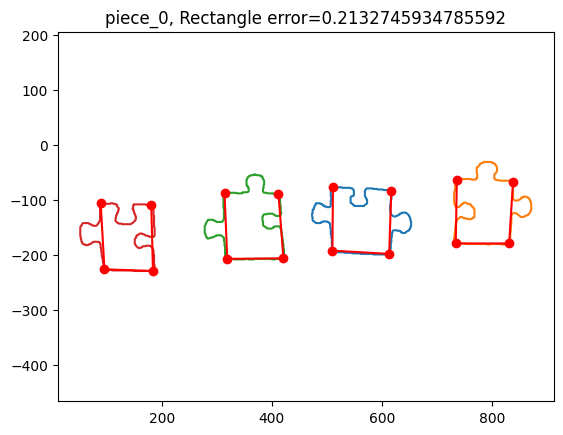

In [15]:
# Show the pieces having the best / worst rectangle
pieces.sort(key= lambda piece: piece.rectangle_error)

# for piece in pieces[:1] + pieces[-1:]:
for piece in pieces:
    plt.title(f"{piece.name}, Rectangle error={piece.rectangle_error}")
    plot_contour(piece.contour)
    plot_contour(piece.contour[piece.corner_indices], marker='o', ls='', color='red')
    if DEBUG:
        plt.show()

# Show all rectangles
for piece in pieces:
    plot_contour(piece.contour[piece.corner_indices], marker='', ls='-', color='red')


## Extract edges

In [16]:
from collections import Counter

def sub_contour(c, idx0, idx1):
    if idx1 > idx0:
        return c[idx0:idx1]
    else:
        return np.concatenate([c[idx0:], c[:idx1]])


def transform_point(point, transform):
    matrix, translate = transform
    return (cv2.transform(np.array([[point]]), matrix) + translate)[0, 0]

def transform_contour(contour, transform):
    matrix, translate = transform
    return cv2.transform(contour, matrix) + translate

def get_transform(center, x, y, degrees):
    matrix = cv2.getRotationMatrix2D(center, degrees, 1)
    translate = (x, y) - center
    return (matrix, translate)

def get_contour_transform(contour, idx, x, y, degrees):
    return get_transform(contour[idx][0], x, y, degrees)

def plot_point(point, **kwargs):
    plot_contour(np.array([[point]]), **kwargs)


In [17]:
for piece in pieces:
    edges = LoopingList()
    for quarter in range(4):
        idx0 = piece.corner_indices[quarter]
        idx1 = piece.corner_indices[quarter+1]
        p0 = piece.contour[idx0][0]
        p1 = piece.contour[idx1][0]
        # normalize the contour: first point at (0, 0), last point at (X, 0)
        dx, dy = p1 - p0
        straight_length=math.sqrt(dx**2 + dy**2)
        angle_degrees = math.degrees(math.atan2(dy, dx))

        transform = get_contour_transform(piece.contour, idx0, 0, 0, angle_degrees)
        normalized_piece_contour = transform_contour(piece.contour, transform)
        normalized_edge_contour = sub_contour(normalized_piece_contour, idx0, idx1 + 1)
        normalized_piece_center = transform_point(piece.center, transform)

        # compute the sign of the edge
        heights = normalized_edge_contour[:, 0, 1]
        if np.max(np.abs(heights)) > 10:
            sign = 1 if np.max(heights) > - np.min(heights) else -1
        else:
            sign = 0

        # rotate male contours by 180° for easy match with female contours
        if sign == 1:
            angle_degrees += 180
            transform = get_contour_transform(piece.contour, idx1, 0, 0, angle_degrees)
            normalized_piece_contour = transform_contour(piece.contour, transform)
            normalized_piece_center = transform_point(piece.center, transform)

        edge = Edge(
            idx0=idx0,
            idx1=idx1,
            normalized_piece_contour=normalized_piece_contour,
            normalized_piece_center=normalized_piece_center,
            angle_degrees=angle_degrees,
            sign=sign,
            straight_length=straight_length,
        )
        edges.append(edge)

    for idx, edge in enumerate(edges):
        edge.update(
            prev=edges[idx-1],
            next=edges[idx+1]
        )

    piece.update(
        edges=edges,
        nb_flats=len([edge for edge in edges if edge.sign == 0])
    )

print("edge sign:", Counter([edge.sign for piece in pieces for edge in piece.edges]))
print("nb of flats:", Counter([piece.nb_flats for piece in pieces]))

flat_pieces = [piece for piece in pieces if piece.nb_flats > 0]


edge sign: Counter({1: 7, -1: 5, 0: 4})
nb of flats: Counter({1: 4})


### Show edges

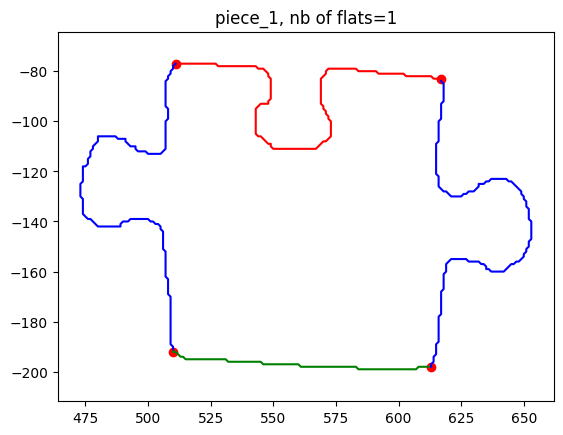

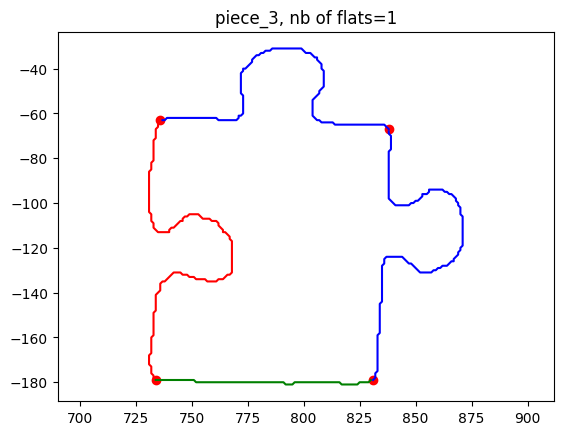

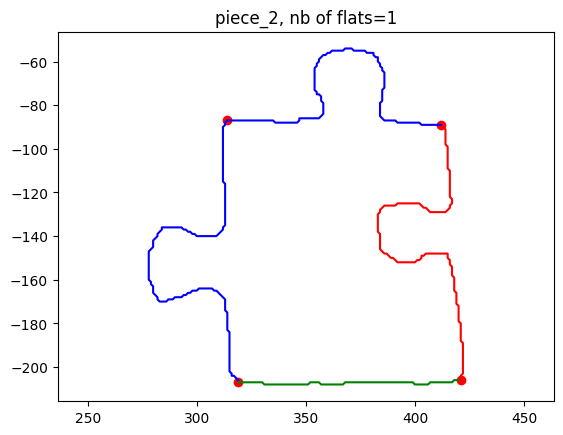

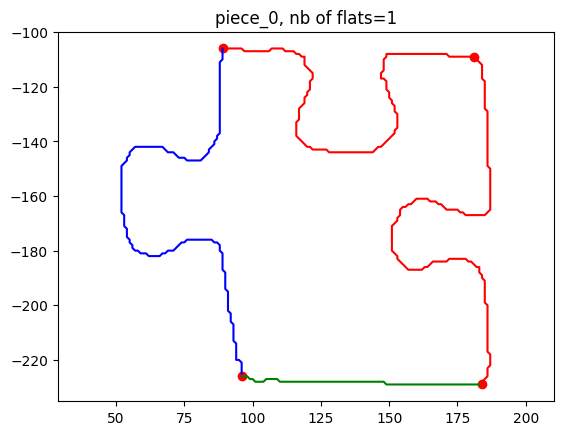

In [18]:
for piece in flat_pieces:
    for edge in piece.edges:
        if edge.sign == 0 and edge.prev.sign != 0:
            first_flat = edge
        if edge.sign == 0 and edge.next.sign != 0:
            last_flat = edge
    piece.update(
        first_flat = first_flat,
        last_flat = last_flat,
        before_flat = first_flat.prev,
        after_flat = last_flat.next,
    )

# Show the pieces having the smallest / highest number of flats
pieces.sort(key= lambda piece: piece.nb_flats)

sign2color = {-1: "red", 0: "green", 1: "blue"}

for piece in pieces:
    plt.title(f"{piece.name}, nb of flats={piece.nb_flats}")
    plot_contour(piece.contour[piece.corner_indices], marker='o', ls='', color='red')
    for edge in piece.edges:
        plot_contour(sub_contour(piece.contour, edge.idx0, edge.idx1), c=sign2color[edge.sign])
    plt.show()


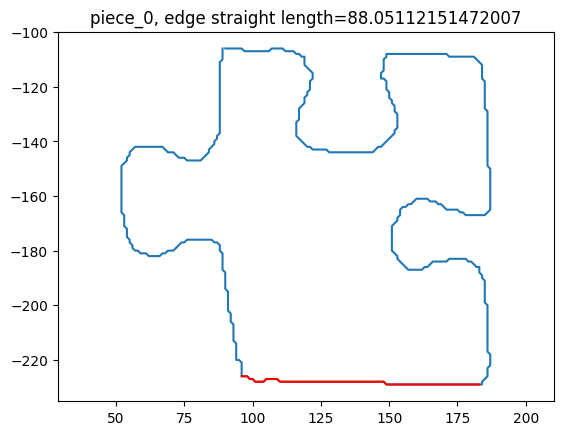

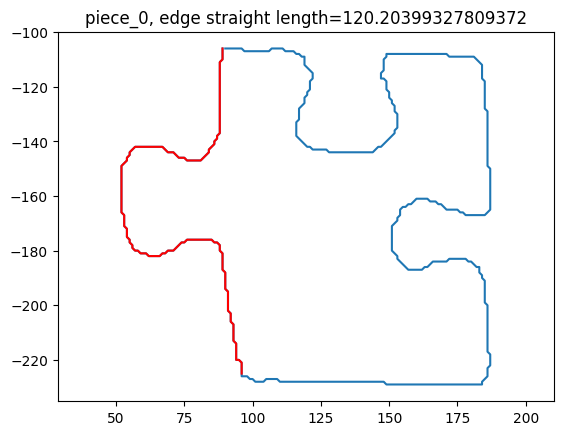

In [19]:

# Show the pieces having the min/max edge straight length
edge_pieces = [(edge, piece) for piece in pieces for edge in piece.edges]
edge_pieces.sort(key= lambda ep: ep[0].straight_length)

for edge, piece in edge_pieces[:1] + edge_pieces[-1:]:
    plt.title(f"{piece.name}, edge straight length={edge.straight_length}")
    plot_contour(piece.contour)
    plot_contour(sub_contour(piece.contour, edge.idx0, edge.idx1), c='red')
    plt.show()


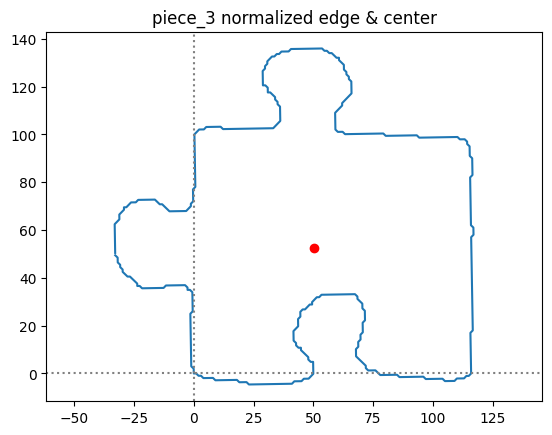

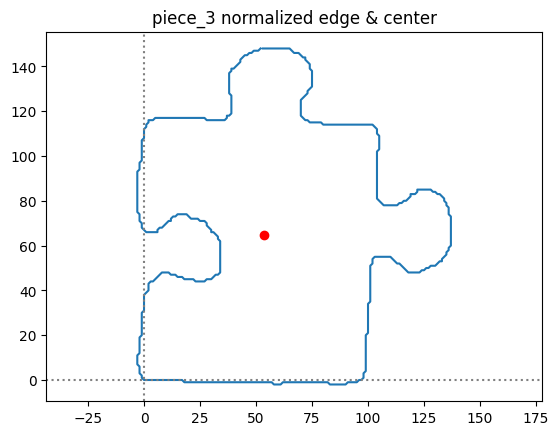

In [20]:
# Show some normalized edges
import random

for piece in random.sample(pieces, 1):
    for edge in piece.edges[:2]:
        plt.title(f"{piece.name} normalized edge & center")
        plot_contour(edge.normalized_piece_contour)
        plot_point(edge.normalized_piece_center, marker='o', c='red')
        plt.axhline(0, c='gray', ls=':')
        plt.axvline(0, c='gray', ls=':')
        plt.show()


# Compute puzzle size


## Calculate straight length

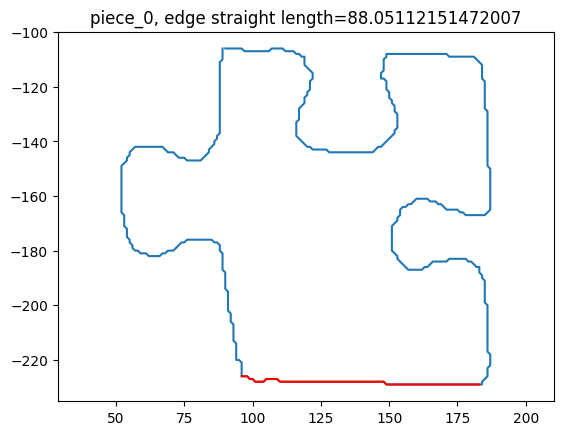

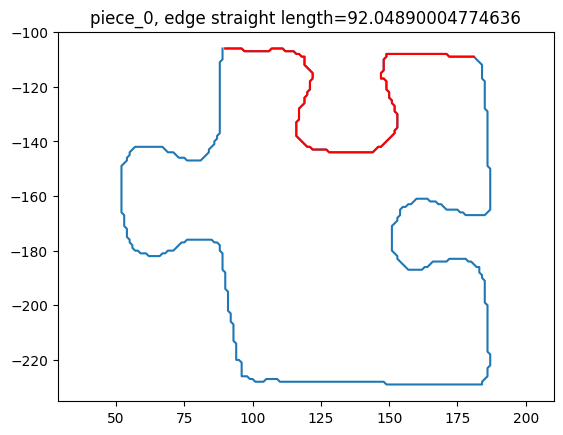

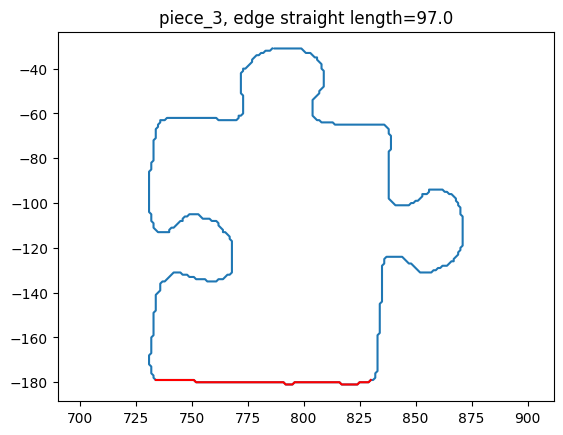

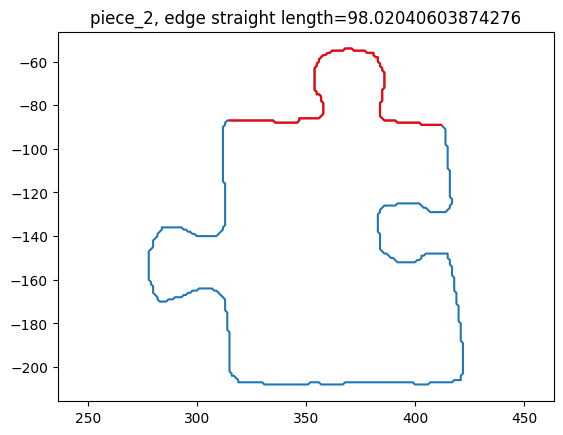

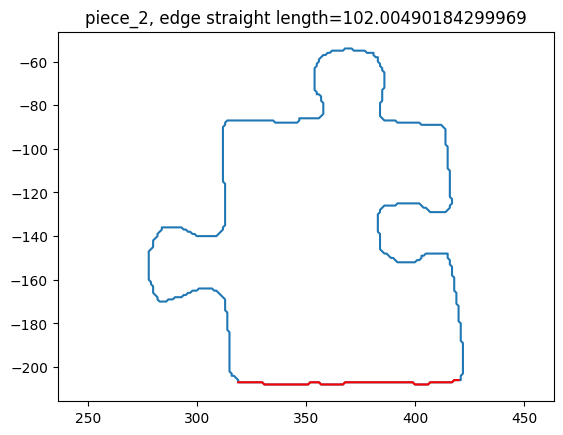

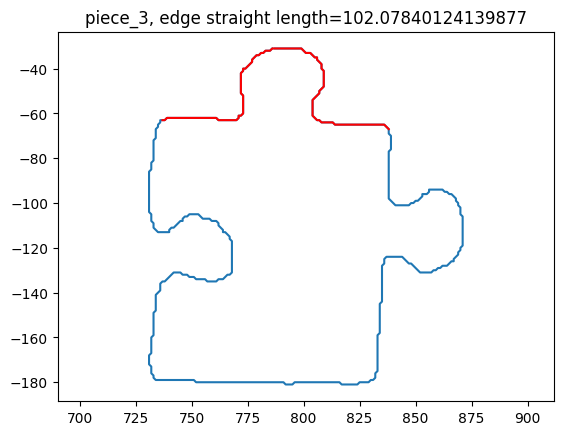

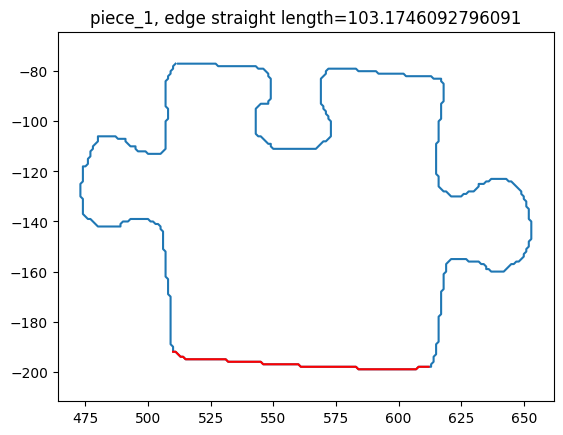

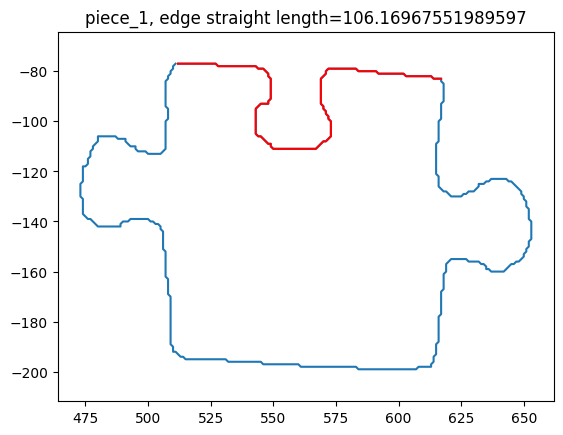

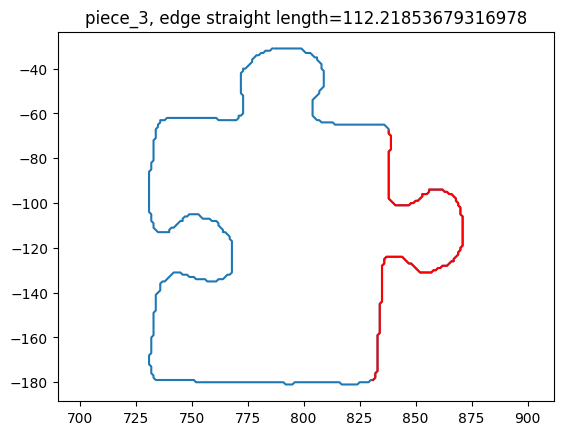

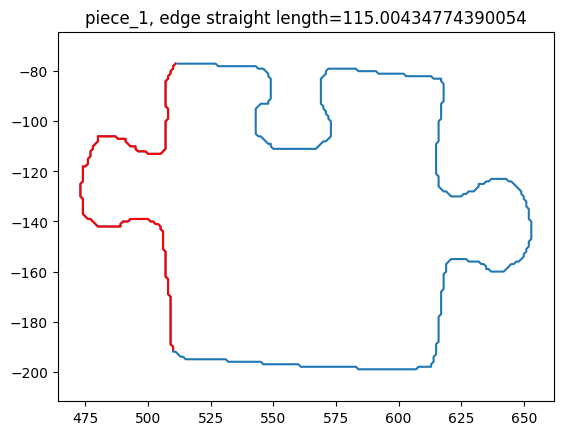

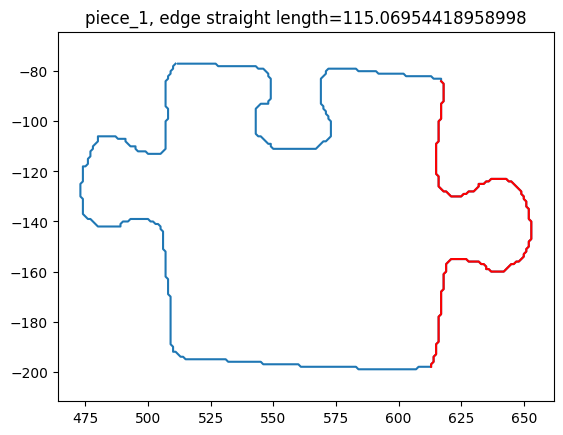

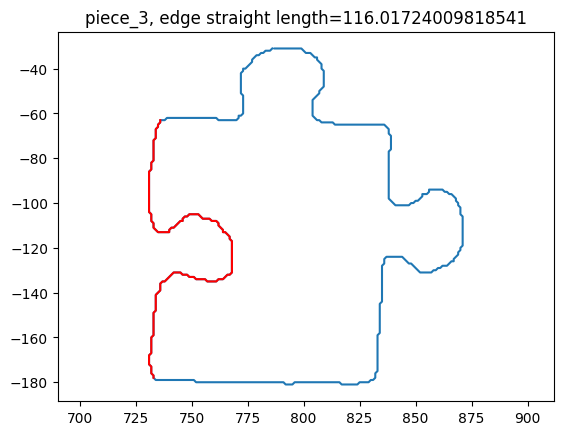

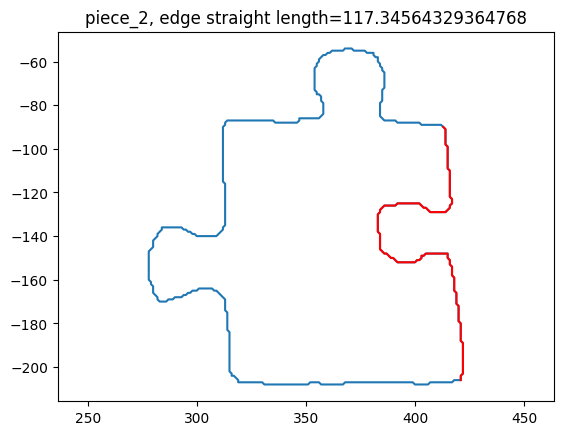

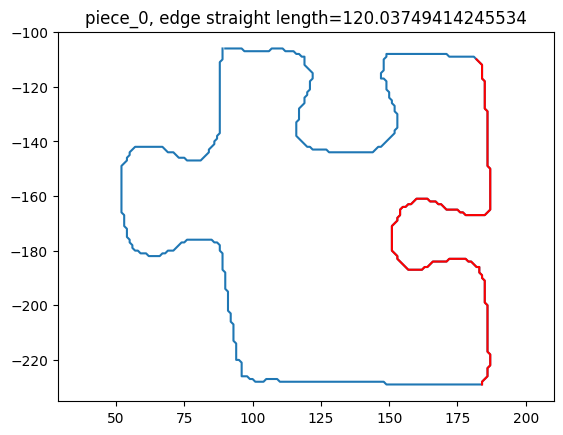

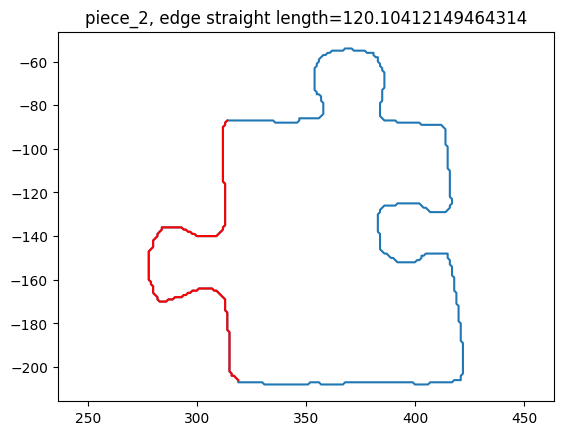

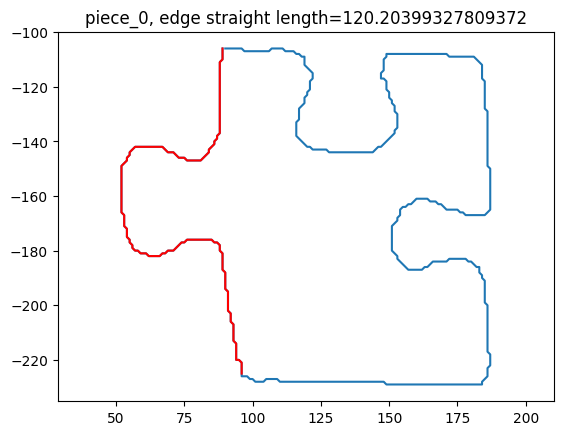

In [21]:
# Show the pieces having the min/max edge straight length
edge_pieces = [(edge, piece) for piece in pieces for edge in piece.edges]
edge_pieces.sort(key= lambda ep: ep[0].straight_length)

for edge, piece in edge_pieces:
    plt.title(f"{piece.name}, edge straight length={edge.straight_length}")
    plot_contour(piece.contour)
    plot_contour(sub_contour(piece.contour, edge.idx0, edge.idx1), c='red')
    plt.show()


In [22]:
## Show some normalized edges
#import random
#
#for piece in random.sample(pieces, 1):
#    for edge in piece.edges[:2]:
#        plt.title(f"{piece.name} normalized edge & center")
#        plot_contour(edge.normalized_piece_contour)
#        plot_point(edge.normalized_piece_center, marker='o', c='red')
#        plt.axhline(0, c='gray', ls=':')
#        plt.axvline(0, c='gray', ls=':')
#        plt.show()
#

## Calculate size

In [23]:
"""# Compute puzzle size"""

# def compute_size(area, perimeter):
#     # perimeter = 2 * (H+W)
#     # area = H*W
#     # H**2 - perimeter/2 * H + area = 0
#     a = 1
#     b = -perimeter/2
#     c = area
#     delta = b**2 - 4*a*c
#     h = int((-b - math.sqrt(delta)) / (2*a))
#     w = int((-b + math.sqrt(delta)) / (2*a))
#     return (min(h, w), max(h, w))
# 
# 
# nb_flats = Counter([piece.nb_flats for piece in pieces])
# print(nb_flats)
# assert nb_flats[2] == 4
# area = len(pieces)
# perimeter = nb_flats[1] + 2*nb_flats[2]
# w, h = compute_size(area, perimeter)
# print(f"Size of puzzle grid: {w} x {h}")
# assert w * h == area
# assert 2 * (w + h) == perimeter
# 
# solution.update(grid_size = (w, h))


'# Compute puzzle size'

# Create edges vector features

## Sample edges

In [ ]:
NB_SAMPLES = 120
NB_SAMPLES = 9

for piece in pieces:
    for edge in piece.edges:
        # compute the distance from the first point, this is not exactly edge.arc_length
        edge_contour = sub_contour(edge.normalized_piece_contour, edge.idx0, edge.idx1 + 1)
        deltas = edge_contour[1:] - edge_contour[:-1]
        distances = np.cumsum(np.sqrt(np.sum(deltas**2, axis=2)))
        arc_length = distances[-1]
        distance = arc_length / (NB_SAMPLES - 1)  # distance between 2 sample points
        # get N equidistant points
        sample_indices = (np.array([np.argmax(distances >= i*distance - 0.0001) for i in range(NB_SAMPLES)]) + edge.idx0) % len(piece.contour)

        edge.update(
            sample_indices=sample_indices,
            arc_length=arc_length,
        )

In [25]:
## Show the pieces having the min/max edge arc length
#edge_pieces = [(edge, piece) for piece in pieces for edge in piece.edges]
#edge_pieces.sort(key= lambda ep: ep[0].arc_length)
#
#for edge, piece in edge_pieces[:1] + edge_pieces[-1:]:
#    plt.title(f"{piece.name}, edge arc length={edge.arc_length}")
#    plot_contour(piece.contour)
#    plot_contour(sub_contour(piece.contour, edge.idx0, edge.idx1), c='red')
#    plot_contour(piece.contour[edge.sample_indices], marker='o', ls='', color='red')
#    plt.show()


# Match pieces

In [ ]:
solution = Solution()


def match_edges(edge1:Edge, edge2:Edge):
    if edge1.sign != edge2.sign:
        return False
    

def match_edge_points(edge1:Edge, edge2:Edge):
    pass

def match_pieces(piece1:Piece, piece2:Piece):
    for edge1 in piece1.edges:
        for edge2 in piece2.edges:
            if match_edge_points(edge1, edge2):
                return True
    return False

    

In [60]:
matches = []

for p1 in pieces:
    for e1 in p1.edges:
        if e1.sign == 0:
            continue
        for p2 in pieces:
            if p1 == p2:
                continue

            for e2 in p2.edges:
                if e2.sign == 0:
                    continue
                if e1.sign != e2.sign:
                    continue
                distance = np.linalg.norm(e1.sample_indices - e2.sample_indices)
                if distance < 100:
                    matches.append((p1, e1, p2, e2, distance))


print(matches)
for m in matches:
    print(m[0].name, m[2].name, m[4])



[(<__main__.Piece object at 0x000002BFF3B07D90>, <__main__.Edge object at 0x000002BFF38E30E0>, <__main__.Piece object at 0x000002BFF38E1D30>, <__main__.Edge object at 0x000002BF875C3CB0>, np.float64(12.529964086141668)), (<__main__.Piece object at 0x000002BFF3B07D90>, <__main__.Edge object at 0x000002BF870336F0>, <__main__.Piece object at 0x000002BFF38E1D30>, <__main__.Edge object at 0x000002BF874EB4D0>, np.float64(29.866369046136157)), (<__main__.Piece object at 0x000002BFF38E1D30>, <__main__.Edge object at 0x000002BF875C3CB0>, <__main__.Piece object at 0x000002BFF3B07D90>, <__main__.Edge object at 0x000002BFF38E30E0>, np.float64(12.529964086141668)), (<__main__.Piece object at 0x000002BFF38E1D30>, <__main__.Edge object at 0x000002BF874EB4D0>, <__main__.Piece object at 0x000002BFF3B07D90>, <__main__.Edge object at 0x000002BF870336F0>, np.float64(29.866369046136157))]
piece_1 piece_0 12.529964086141668
piece_1 piece_0 29.866369046136157
piece_0 piece_1 12.529964086141668
piece_0 piece_

## Border

In [27]:
import heapq

MAX_MATCH_SCORE = 2000
MAX_MATCH_SCORE = 200

In [28]:
points_before_flat = {}  # key=piece, value=sample points
points_after_flat = {}
for piece in flat_pieces:
    points_before_flat[piece] = piece.first_flat.normalized_piece_contour[piece.before_flat.sample_indices][::-1]
    points_after_flat[piece] = piece.last_flat.normalized_piece_contour[piece.after_flat.sample_indices]

matches_after_flat = {}  # key=piece0, value=[(score1, piece1)]
for piece0 in flat_pieces:
    points0 = points_after_flat[piece0]
    matches = []
    for piece1, points1 in points_before_flat.items():
        diff = points1 - points0
        offset = np.mean(diff, axis=0)
        score = np.sum((diff - offset)**2)
        if score < MAX_MATCH_SCORE:
            matches.append((score, piece1))
    matches.sort()
    matches_after_flat[piece0] = matches


In [29]:
if len(matches_after_flat) != 0:
    sum_score = sum([matches[0][0] for matches in matches_after_flat.values()])
    first_piece = piece_by_name['piece_1']
    paths = [(sum_score, [first_piece])]
    heapq.heapify(paths)
    for _ in range(100):
        score, ordered_border = heapq.heappop(paths)
        if len(ordered_border) == len(flat_pieces) + 1:
            print("Minimum score:", sum_score)
            print("Score of the border:", score)
            break
        last_piece = ordered_border[-1]
        print(last_piece.name)
        print(list(map(lambda x: x.name, matches_after_flat.keys())))
        matches = matches_after_flat[last_piece]
        print(matches)
        for match_score, next_piece in matches:
            if next_piece not in ordered_border[1:]:
                heapq.heappush(paths, (score + match_score - matches[0][0], ordered_border.copy() + [next_piece]))

    print("Computed border pieces: ", ' '.join([piece.name for piece in ordered_border]))
else:
    print("No matches found")

# assert ordered_border[-1] == ordered_border[0]  # loop on the first piece
# ordered_border = ordered_border[:-1]  # remove the repeated first piece
# h, w = solution.grid_size
# if ordered_border[h-1].nb_flats == 1:
#     h, w = w, h
#     solution.grid_size = w, h
# assert [idx for idx, piece in enumerate(ordered_border) if piece.nb_flats == 2] == [0, h-1, h+w-2, 2*h+w-3]


IndexError: list index out of range

### Place the border

In [ ]:
PAD = 30

solution.update(
    grid={} # key=(i, j), value=Cell
)

border_positions = []

def place_border():
    i, j = 0, 0
    x, y = 0, 0
    it_pieces = iter(ordered_border)
    for quarter, (di, dj) in zip([2, 3, 0, 1, 2], [(0, 0), (0, 1), (1, 0), (0, -1), (-1, 0)]):
        for piece in it_pieces:
            i += di
            j += dj
            flat_edge = piece.first_flat
            top_edge_idx = (piece.edges.index(flat_edge) - quarter) % 4
            if (i, j) == (0, 0):
                idx = flat_edge.idx1  # reference (xy) point is the corner
            else:
                idx = flat_edge.idx0

            transform = get_contour_transform(flat_edge.normalized_piece_contour, idx, x, y, 90 * quarter)
            cell = Item(
                piece = piece,
                top_edge_idx = top_edge_idx,
                contour = transform_contour(flat_edge.normalized_piece_contour, transform),
            )
            solution.grid[i, j] = cell
            border_positions.append((i, j))

            x, y = cell.contour[piece.last_flat.idx1][0]
            if piece.nb_flats == 2:
                break

place_border()

plt.title("Border")
for cell in solution.grid.values():
   plot_contour(cell.contour, c='blue', ls='-')
plt.show()

plt.title("Top edge")
for cell in solution.grid.values():
   top_edge = cell.piece.edges[cell.top_edge_idx]
   plot_contour(sub_contour(cell.contour, top_edge.idx0, top_edge.idx1), c='red')


## Inner pieces

In [ ]:
piece_edge_points = {}  # key=(piece, edge), value=sample points
for piece in pieces:
    for edge in piece.edges:
        if edge.sign != 0 and edge.prev.sign != 0 and edge.next.sign != 0:
            piece_edge_points[(piece, edge)] = edge.normalized_piece_contour[edge.sample_indices]


In [ ]:
piece_edge_points

{(<__main__.Piece at 0x1e83d437d90>,
  <__main__.Edge at 0x1e8508a36f0>): array([[[-1.13686838e-13, -1.42108547e-14]],
 
        [[ 2.10794654e+01,  8.10024139e-01]],
 
        [[ 4.31573326e+01,  1.56353497e+00]],
 
        [[ 4.51352985e+01, -1.65772382e+01]],
 
        [[ 5.23313269e+01, -3.10069705e+01]],
 
        [[ 7.26384437e+01, -2.61468257e+01]],
 
        [[ 6.76652723e+01, -7.83651260e+00]],
 
        [[ 8.41483216e+01,  2.44891019e-01]],
 
        [[ 1.05171274e+02,  5.65133120e-02]]]),
 (<__main__.Piece at 0x1e83c1aba80>,
  <__main__.Edge at 0x1e8508d2ad0>): array([[[ 1.02078401e+02, -2.84217094e-14]],
 
        [[ 8.30146230e+01, -1.25393813e+00]],
 
        [[ 6.77126592e+01, -8.66001024e+00]],
 
        [[ 7.10042469e+01, -2.68029276e+01]],
 
        [[ 5.37038192e+01, -3.41306286e+01]],
 
        [[ 3.80295925e+01, -2.55098039e+01]],
 
        [[ 3.67756543e+01, -6.44602572e+00]],
 
        [[ 2.09446854e+01, -1.82212885e+00]],
 
        [[ 9.99231951e-01, -3.91855667

In [32]:

piece_edge_matches = {}  # key=(piece0, edge0), value=[(score1, piece1, edge1)]
for (piece0, edge0), points0 in piece_edge_points.items():
    points0 = points0[::-1]
    matches = []
    for (piece1, edge1), points1 in piece_edge_points.items():
        if edge0.sign != edge1.sign:
             diff = points1 - points0
             offset = np.mean(diff, axis=0)
             score = np.sum((diff - offset)**2)
             if score < 2000:
                 matches.append((score, piece1, edge1))

    matches.sort()
    piece_edge_matches[piece0, edge0] = matches

edge_pair_score = {}  # key=(edge0, edge1), value=matching score
edge_min_score = {}  # key=edge, value=min matching score
for piece in pieces:
    for edge in piece.edges:
        matches = piece_edge_matches.get((piece, edge), None)
        if matches:
            edge_min_score[edge] = matches[0][0]
            for match_score, match_piece, match_edge in matches:
                edge_pair_score[edge, match_edge] = match_score

min_inner_score = sum(edge_min_score.values()) / 2
print(min_inner_score)

# we will fill puzzle pieces in a spiral for improved piece placement accuracy

w, h = solution.grid_size
all_positions = border_positions.copy()

i, j = 1, 0
for (di, dj) in itertools.cycle([(0, 1), (1, 0), (0, -1), (-1, 0)]):
    while (i+di, j+dj) not in all_positions:
        i += di
        j += dj
        all_positions.append((i, j))
    if len(all_positions) == w*h:
        break

inner_positions = all_positions[len(border_positions):]

def inner_matches(i, j, grid):
    scores = {}  # key=(piece, top_edge_idx), value=score
    directions = []
    for direction, dpos in zip([2, 3, 0, 1], [(0, 1), (1, 0), (0, -1), (-1, 0)]):
        di, dj = dpos
        if (i+di, j+dj) in grid:
            directions.append(direction)
            neighbour = grid[i+di, j+dj]
            neighbour_edge = neighbour.piece.edges[neighbour.top_edge_idx + direction]

            for match_score, match_piece, match_edge in piece_edge_matches[neighbour.piece, neighbour_edge]:
                match_top_edge_idx = (match_piece.edges.index(match_edge) + 2 - direction) % 4
                scores.setdefault((match_piece, match_top_edge_idx), []).append(2 * match_score - edge_min_score[match_edge] - edge_min_score[neighbour_edge])

    matches = [(sum(match_scores), candidate, candidate_top_edge_idx) for (candidate, candidate_top_edge_idx), match_scores in scores.items() if len(match_scores) == len(directions)]
    matches.sort(key=lambda m: m[0])
    return matches

def place_inner_piece(i, j, cell):
    translations = []  # translations from piece.center
    rotations = []  # angle in degrees
    for direction, dpos in zip([2, 3, 0, 1], [(0, 1), (1, 0), (0, -1), (-1, 0)]):
        di, dj = dpos
        if (i+di, j+dj) in grid:
            neighbour = grid[i+di, j+dj]
            neighbour_edge = neighbour.piece.edges[neighbour.top_edge_idx + direction]
            x0, y0 = neighbour.contour[neighbour_edge.idx0][0]
            x1, y1 = neighbour.contour[neighbour_edge.idx1][0]
            dx, dy = x1-x0, y1-y0

            match_edge = cell.piece.edges[cell.top_edge_idx + direction + 2]
            angle_degrees = 90 * (3 + match_edge.sign) - math.degrees(math.atan2(dy, dx))
            transform = get_contour_transform(match_edge.normalized_piece_contour, match_edge.idx1, x0, y0, angle_degrees)
            translations.append(transform_point(match_edge.normalized_piece_center, transform))
            rotations.append((match_edge.angle_degrees + angle_degrees) % 360)

    angle_degrees = stats.circmean(rotations, high=360)
    x = statistics.mean([translation[0] for translation in translations])
    y = statistics.mean([translation[1] for translation in translations])
    transform = get_transform(cell.piece.center, x, y, angle_degrees)
    cell.contour = transform_contour(cell.piece.contour, transform)


w, h = solution.grid_size

nodes = [(min_inner_score, solution.grid.copy(), set())]  # (score, grid, used_inner_pieces)
heapq.heapify(nodes)
while len(nodes) > 0:
    grid_score, grid, used_inner_pieces = heapq.heappop(nodes)

    if len(used_inner_pieces) == 0:
        pass
    else:
        i, j = inner_positions[len(used_inner_pieces) - 1]
        place_inner_piece(i, j, grid[i, j])  # properly place the last piece

    if len(used_inner_pieces) == len(inner_positions):
        break

    i, j = inner_positions[len(used_inner_pieces)]  # next position to fill
    for match_score, match_piece, match_top_edge_idx in inner_matches(i, j, grid):
        if match_piece not in used_inner_pieces:
            cell = Item(
                piece = match_piece,
                top_edge_idx = match_top_edge_idx,
            )
            grid2 = grid.copy()
            grid2[i, j] = cell
            used_inner_pieces2 = used_inner_pieces.copy()
            used_inner_pieces2.add(match_piece)
            heapq.heappush(nodes, (grid_score + match_score, grid2, used_inner_pieces2))

print(min_inner_score)
print(grid_score)
for j in range(h):
    print(' '.join([f"{grid[i, j].piece.name if (i, j) in grid else ''}\t" for i in range(w)]))

for ij, cell in grid.items():
    i, j = ij
    plot_contour(cell.contour)

assert len(used_inner_pieces) == len(inner_positions)

NameError: name 'piece_edge_points' is not defined